In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import numpy as np
import random
import gym
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [3]:


data = pd.read_excel('Risk_Analysis_Data_Adjusted.xlsx', sheet_name=None)

'''Calculates percent change from previous price/value'''
def calc_percent_changes(data):
    new_values = []
    for idx in range(len(data)):
        if idx - 1 < 0:
            new_values.append(1.0)
        else: 
            new_values.append(data.loc[idx] / data.loc[idx - 1])
    return new_values


'''Standardize all companys' data'''
def standardize_company_dataframes(all_data):
    datas = []
    closing_prices_arr = []
    final_data_df = pd.DataFrame({})
    final_prices_df = pd.Series()
    reset_flags = []
        

    for name, data in all_data.items():
        data = data[['Close', 'Volume', 'DebtToEquity', 'EarningsPerShare', 'Crossover Signal', 'RSI 14 Period', 'ADX 14 Period']]
        data = data.dropna()
        data = data.apply(lambda col: col[::-1]) # Reverse for chronological order
        closing_prices = data['Close']

        scaler = StandardScaler()

        # Fit scaler on the data and transform the data
        df_normalized = scaler.fit_transform(data)

        # Convert the result back to a DataFrame
        data = pd.DataFrame(df_normalized, columns=data.columns)

        # Calculate percent change from last closing price
        data['Close'] = calc_percent_changes(closing_prices)
        data['Volume'] = calc_percent_changes(data['Volume'])
        data['EarningsPerShare'] = calc_percent_changes(data['EarningsPerShare'])

        datas.append(data)
        closing_prices_arr.append(closing_prices)
        
    #Find min length
    min_len = float('inf')
    for data in datas:
        min_len = min(min_len, len(data))

    for data, closing_prices in zip(datas, closing_prices_arr):
        truncated_data = data.iloc[:min_len]
        truncated_prices = closing_prices[:min_len]
        
        final_data_df = pd.concat([final_data_df, truncated_data])
        final_prices_df = pd.concat([final_prices_df, truncated_prices])
        
    return final_data_df, final_prices_df, min_len



'''Standardize a companies data'''
def standardize_company_dataframe(stock_data):

    data = stock_data.drop(stock_data.columns[0], axis=1).dropna()
    data = data[['Close', 'Volume', 'DebtToEquity', 'EarningsPerShare', 'Crossover Signal', 'RSI 14 Period', 'ADX 14 Period']]
    data = data.apply(lambda col: col[::-1]) # Reverse for chronological order

    closing_prices = data['Close']

    scaler = StandardScaler()

    # Fit scaler on the data and transform the data
    df_normalized = scaler.fit_transform(data)

    # Convert the result back to a DataFrame
    data = pd.DataFrame(df_normalized, columns=data.columns)
        
    # Calculate percent change from last closing price
    data['Close'] = calc_percent_changes(closing_prices)
    data['Volume'] = calc_percent_changes(data['Volume'])
    data['EarningsPerShare'] = calc_percent_changes(data['EarningsPerShare'])
        
    return data.reset_index(drop=True), closing_prices.reset_index(drop=True)
        
    
# Data and closing prices for 10 stocks
apple_data, apple_closing_prices = standardize_company_dataframe(data['AAPL'])
corvel_data, corvel_closing_prices = standardize_company_dataframe(data['CRVL'])
eight_data, eight_closing_prices = standardize_company_dataframe(data['EGHT'])
ibm_data, ibm_closing_prices = standardize_company_dataframe(data['IBM'])
intel_data, intel_closing_prices = standardize_company_dataframe(data['INTC'])
adobe_data, adobe_closing_prices = standardize_company_dataframe(data['ADBE'])
microsoft_data, microsoft_closing_prices = standardize_company_dataframe(data['MSFT'])
insight_data, insight_closing_prices = standardize_company_dataframe(data['NSIT'])
pro_data, pro_closing_prices = standardize_company_dataframe(data['PRO'])
rambus_data, rambus_closing_prices = standardize_company_dataframe(data['RMBS'])


# All company data into singular dataframes
all_data, all_closing_prices, min_data_len = standardize_company_dataframes(data)


print(f'All dataframes have length of: {min_data_len}')
all_data = all_data.reset_index(drop=True)
all_closing_prices = all_closing_prices.reset_index(drop=True)
all_data


C:\Users\rober\AppData\Local\Temp\ipykernel_19604\1494835070.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  final_prices_df = pd.Series()


All dataframes have length of: 3210


,Close,Volume,DebtToEquity,EarningsPerShare,Crossover Signal,RSI 14 Period,ADX 14 Period
0,1.000000,1.000000,-1.069681,1.000000,0.004550,0.522705,-0.219235
1,1.004916,1.057204,-1.069681,0.895022,0.004550,-0.002582,-0.269555
2,0.995225,0.841251,-1.069681,0.941146,0.004550,-0.241070,-0.424491
3,1.007048,1.054594,-1.069681,0.857634,0.004550,-0.726281,-0.551062
4,1.008528,0.840430,-1.069681,1.094118,0.004550,-0.443359,-0.647951
...,...,...,...,...,...,...,...
32095,1.024544,-0.150156,-1.101995,1.070223,-0.003399,0.412390,-1.016986
32096,1.021903,-30.043473,-1.101995,0.887516,-0.003399,-0.262301,-1.095133
32097,0.980576,3.633806,-1.101995,1.261557,-0.003399,0.759089,-1.013045
32098,1.007514,1.125819,-1.101995,1.139368,-0.003399,1.230788,-0.819845


In [4]:

class Parameters:    
    def __init__(self, epsilon=0.99):
        
        #self.seed = 42
        self.episodes = 10  
        self.state_dim = 7 # state dim 
        self.action_dim = 3

        # Algorithm hyperparameters
        self.gamma = 0.95
        self.epsilon = epsilon
        self.epsilon_decay = 0.993
        
        self.lr = 0.001
        self.memory_capacity = 500 # Experience replay size
        self.batch_size = 64
        
        self.hidden_dim = 64
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
        

'''
Neural network with 3 layers and Relu activation
that represents both target network and policy network
'''
class NN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)  # input layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)  # output layer

    def forward(self, x):
        # Relu activation functions
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class DQN: 
    def __init__(self, state_dim, action_dim, params):
        self.device = params.device

        self.policy_network = NN(state_dim, action_dim, params.hidden_dim).to(self.device)
        self.target_network = NN(state_dim, action_dim, params.hidden_dim).to(self.device)
        
        # Copy weights from policy net
        self.target_network.load_state_dict(self.policy_network.state_dict()) 
        self.target_network.eval()  # Target network's weights don't update

        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=params.lr)
        self.loss_fn = nn.MSELoss()
        self.memory = deque(maxlen=params.memory_capacity)
        self.batch_size = params.batch_size
        self.gamma = params.gamma
        self.epsilon = params.epsilon
        self.epsilon_decay = params.epsilon_decay
        
        
    '''Store state transition in memory buffer'''
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((np.array(state), action, reward, next_state, done))
        
    '''Handles choosing an action'''
    def act(self, state, can_buy, can_sell):
        if np.random.rand() <= self.epsilon:
            # Choose random action from either 0 or 1, or 1 and 2
            if can_buy and can_sell:
                return random.randrange(3) 
            elif not can_buy:
                return random.randrange(2)
            elif not can_sell:
                return random.randrange(2) + 1
    
            return 100 # Should not reach - throws error
        
        with torch.no_grad():
            # Obtains Q values for all possible actions 
            q_values = self.policy_network(torch.tensor(state, device=self.device, dtype=torch.float32)) 

            # Returns best action
            if can_buy and can_sell:
                return torch.argmax(q_values).item()
    
            elif not can_buy:
                return torch.argmax(q_values[:2]).item()

            elif not can_sell:
                return torch.argmax(q_values[1:]).item() + 1
            
                
    '''Learn from state transitions stored in memory'''
    def replay(self):
        if len(self.memory) < self.batch_size:
            return 0
        
        # Randomly sample batch from memory and unpack
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.tensor(states, device=self.device, dtype=torch.float32)
        actions = torch.tensor(actions, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, device=self.device, dtype=torch.float32)
        next_states = torch.tensor(next_states, device=self.device, dtype=torch.float32)
        dones = torch.tensor(dones, device=self.device, dtype=torch.float32)

        # Get Q values for current state s
        q_values = self.policy_network(states).gather(dim=1, index=actions)
                
        # Get Q values for next state s'
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        
        # Bellman to calculate expected rewards of s'
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # compute loss between target q values and predicted q values
        loss = self.loss_fn(q_values, expected_q_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        
        for param in self.policy_network.parameters():  # avoid gradient explosion by using clip
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        return loss.item()
        
    '''Update target network's weights'''
    def target_train(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.epsilon *= self.epsilon_decay
        
    '''Save weights to file'''
    def save_weights(self):
        torch.save(self.policy_network.state_dict(), 'policy_network.pth')
        torch.save(self.target_network.state_dict(), 'target_network.pth')

    '''Load saved weights'''
    def load_weights(self):
        self.policy_network.load_state_dict(torch.load('policy_network.pth'))
        self.target_network.load_state_dict(torch.load('target_network.pth'))



In [5]:
import gym
from gym import spaces

class Env(gym.Env):
    
    def __init__(self, data, closing_prices, starting_bal=10000):
        self.data = data
        self.closing_prices = closing_prices.values.ravel()
        self.action_space = spaces.Discrete(3)  # Assuming 3 actions: buy, sell, hold
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(len(data.columns),))
        self.current_step = 0
        
        self.starting_bal = starting_bal # initial starting balance
        self.balance = starting_bal  # Starting balance
        self.portfolio_balance = 0
        self.shares = 0
        
    '''Steps through environment - logic for chosen action, calculating reward, produce next state'''
    def step(self, action, reset_next_stock):
        next_stock = False
        can_buy = True
        can_sell = self.shares > 0
        
        prev_balance = self.balance
        prev_porfolio_balance = self.portfolio_balance

        # Calculate new portfolio balance which is the closing price of current day * shares
        self.portfolio_balance = self.closing_prices[self.current_step] * self.shares
        
        # Perform action: buy, sell, or hold
        # Buy one stock
        if action == 2 and self.balance >= self.closing_prices[self.current_step]:  
            self.balance -= self.closing_prices[self.current_step]
            self.portfolio_balance += self.closing_prices[self.current_step]
            self.shares += 1
            can_buy = True
        elif action == 2:
            can_buy = False
            
        # Sell one stock
        if action == 0 and self.shares > 0:  
            self.balance += self.closing_prices[self.current_step]
            self.portfolio_balance -= self.closing_prices[self.current_step]
            self.shares -= 1
            can_sell = True
        elif action == 0:
            can_sell = False
            
        # Calculate reward
        reward = (self.portfolio_balance + self.balance) - (prev_porfolio_balance + prev_balance)
        
        self.current_step += 1
            
        # End of data
        done = self.current_step == len(self.data) - 1
        if done: next_stock = True
        
        # Switch to next stock in the episode and reset balance and portfolio
        if self.current_step % 3210 == 0 and not done and reset_next_stock:
            self.portfolio_balance = 0
            self.shares = 0
            self.balance = self.starting_bal
            can_buy = True
            can_sell = False
            next_stock = True
        
        # Update state
        next_state = self.data.iloc[self.current_step].values

        return next_state, reward, done, can_buy, can_sell, next_stock
    
    '''Reset environment'''
    def reset(self):
        self.current_step = 0
        self.balance = self.starting_bal
        self.portfolio_balance = 0
        self.shares = 0
        return self.data.iloc[self.current_step].values
    
    '''Return spending money + portfolio money'''
    def get_total_balance(self):
        return self.balance + self.portfolio_balance
        
        

In [75]:


# Initialize Parameters object
params = Parameters()

# Initialize environment
env = Env(all_data, all_closing_prices)

# Create an instance of DQN
dqn = DQN(params.state_dim, params.action_dim, params)


best_reward = 0
rewards = []


for episode in range(280):
    state = env.reset()  # Reset environment to get initial state
    done = False
    episode_reward = []
    total_reward = 0
    
    count = 0
    stock_number = 0
    can_buy = True
    can_sell = False
    
    while not done:
        action = dqn.act(state, can_buy, can_sell) # Choose action
        
        next_state, reward, done, can_buy, can_sell, next_stock = env.step(action, True)
        dqn.remember(state, action, reward, next_state, done) # Store transition in replay memory
        
        loss = dqn.replay()  # Train the agent by replaying experiences from the replay memory
        total_reward += int(reward)
        state = next_state  

        if next_stock:
            stock_number += 1
            episode_reward.append(total_reward)
            total_reward = 0


    dqn.target_train()  # Update the target network at the end of each episode
    
    # Average reward for the episode
    rewards.append(sum(episode_reward)/len(episode_reward))

    # Save the best weights 
    if episode > 4 and dqn.epsilon < 0.2:
        curr_reward = sum(episode_reward)/len(episode_reward)
        
        if curr_reward > best_reward:
            print(f"Old best: {best_reward}, new best: {curr_reward}")
            best_reward = curr_reward
            dqn.save_weights()
            
    print(f"Ep: {episode}, Rewards: {episode_reward}, Avg reward: {sum(episode_reward)/len(episode_reward)}")
    
    # Display epsilon value
    if episode % 20 == 0:
        print(f"Epsilon: {dqn.epsilon}")

avg_reward = sum(rewards) / len(rewards)
print(avg_reward)


Ep: 0, Rewards: [5038, 5887, -407, 545, 666, 9066, 4654, 2852, -517, 2465], Avg reward: 3024.9
Epsilon: 0.98307
Ep: 1, Rewards: [5416, 5543, -676, 1259, 1024, 18204, 10980, 2449, 96, 398], Avg reward: 4469.3
Ep: 2, Rewards: [8380, 12529, -534, 39, 217, 26623, 4583, 2186, 402, 1949], Avg reward: 5637.4
Ep: 3, Rewards: [5027, 4472, -25, 362, 1632, 8829, 3864, 1061, -45, 3018], Avg reward: 2819.5
Ep: 4, Rewards: [2993, 2684, -540, -44, 2170, 28515, 8590, 4393, 1575, 1570], Avg reward: 5190.6
Ep: 5, Rewards: [2885, 3316, -341, 1341, 1128, 14120, 7865, 2162, 382, 1747], Avg reward: 3460.5
Ep: 6, Rewards: [4957, 1082, -859, 1295, 495, 8399, 13468, 1545, 385, 2756], Avg reward: 3352.3
Ep: 7, Rewards: [10519, 1395, -145, 2627, 938, 5499, 15324, 645, 883, 2104], Avg reward: 3978.9
Ep: 8, Rewards: [8054, 3007, -579, 2356, 302, 22580, 7746, 9392, -176, 581], Avg reward: 5326.3
Ep: 9, Rewards: [2056, 1816, 174, 1237, 1499, 4824, 6875, 19375, 1115, 1084], Avg reward: 4005.5
Ep: 10, Rewards: [3686, 

Ep: 82, Rewards: [3665, 4069, -399, 2900, 2614, 8758, 56439, 24567, 2537, 8465], Avg reward: 11361.5
Ep: 83, Rewards: [37153, 54128, -3328, 2132, 4599, 26830, 14749, 16072, 2499, -169], Avg reward: 15466.5
Ep: 84, Rewards: [26840, 2408, -3699, 274, 5971, 74455, 31273, 11159, 2610, 1921], Avg reward: 15321.2
Ep: 85, Rewards: [21659, 5605, 24, 2354, 8936, 45426, 2755, 17756, 1407, 2837], Avg reward: 10875.9
Ep: 86, Rewards: [15476, 42338, -1468, 3975, 2832, 53200, 3766, 10975, 810, 4371], Avg reward: 13627.5
Ep: 87, Rewards: [21559, 2570, -2843, -165, 4245, 79854, 50239, 3667, 1373, 10469], Avg reward: 17096.8
Ep: 88, Rewards: [22043, 18506, -288, 2509, 737, 56624, 39310, 6907, 2733, 18187], Avg reward: 16726.8
Ep: 89, Rewards: [11553, 11493, 206, -1053, 943, 17026, 28831, 811, -312, 3580], Avg reward: 7307.8
Ep: 90, Rewards: [21062, 21531, -1132, 6238, 427, 12808, 13821, 8137, 2801, 3211], Avg reward: 8890.4
Ep: 91, Rewards: [1652, 10742, 2035, 1488, 10937, 69920, 62603, 22882, 4940, 35

Ep: 161, Rewards: [13758, 5283, -8217, 4965, 4637, 53623, 29763, 7861, 1322, 19250], Avg reward: 13224.5
Ep: 162, Rewards: [41085, 2533, -7851, 17, 1383, 22969, 19572, 11729, -221, 21914], Avg reward: 11313.0
Ep: 163, Rewards: [28365, 43492, -809, 4088, 2196, 33897, 21271, 10587, 2386, 20511], Avg reward: 16598.4
Ep: 164, Rewards: [13921, 17585, 1480, 5745, 1486, 62289, 27522, 8789, 346, 7975], Avg reward: 14713.8
Ep: 165, Rewards: [11410, 26071, -213, 529, 9235, 19038, 50737, 29859, -1207, 5947], Avg reward: 15140.6
Ep: 166, Rewards: [2307, 7569, -7857, 527, 6678, 118673, -947, 17150, 6098, 943], Avg reward: 15114.1
Ep: 167, Rewards: [6248, 25683, -2400, 374, 78, 4559, 12000, 48808, 6822, 6588], Avg reward: 10876.0
Ep: 168, Rewards: [3225, 10351, -7730, 2049, 3852, 20132, 5188, 42495, 7775, 18573], Avg reward: 10591.0
Ep: 169, Rewards: [33192, 22236, -5587, 5102, 2118, 135, 6086, 69407, 4194, 1022], Avg reward: 13790.5
Ep: 170, Rewards: [36542, 52429, 460, 3686, 12444, 43521, 13799, 4

Ep: 239, Rewards: [55194, 13562, -216, 3263, 4171, 123546, 2048, 10486, 2386, 20357], Avg reward: 23479.7
Ep: 240, Rewards: [7153, 19209, -5222, 2930, 676, 24444, 61829, 5658, 4391, 4154], Avg reward: 12522.2
Epsilon: 0.18213947565257602
Ep: 241, Rewards: [11155, 15611, 331, -162, 194, 6600, 12492, 46712, 3267, 9149], Avg reward: 10534.9
Ep: 242, Rewards: [90737, 73067, 146, 1613, 3337, 35287, 3427, 9648, 332, 2709], Avg reward: 22030.3
Ep: 243, Rewards: [50015, 41741, -690, -595, 1868, 59247, 4672, 5748, 1052, 14697], Avg reward: 17775.5
Ep: 244, Rewards: [4804, 19433, 513, -830, 463, 1700, 12096, 20877, 4428, 26216], Avg reward: 8970.0
Ep: 245, Rewards: [8241, 34203, -4599, -1338, 3167, 23918, 53049, 29147, 1002, 1745], Avg reward: 14853.5
Ep: 246, Rewards: [42599, 46907, -4619, 6169, 747, 40913, 65572, 23597, 4325, 17301], Avg reward: 24351.1
Ep: 247, Rewards: [322, 10868, -5798, 6309, 21692, 16933, 8399, 23831, 879, 3501], Avg reward: 8693.6
Ep: 248, Rewards: [25997, 60916, 108, 30

Epsilon value: 0.13849202749791037


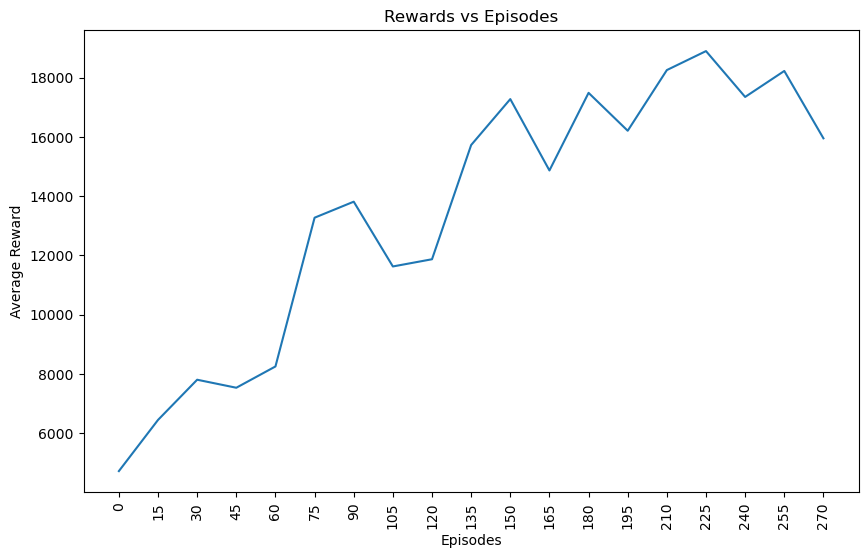

In [76]:

averages_array = []
episodes = 300

for i in range(0, len(rewards), int(episodes/20)):
    # Calculate the average of the current range of 10 elements
    average = np.mean(rewards[i:i+ int(episodes/20)])
    # Store the average in the averages_array
    averages_array.append(average)
    
print(f"Epsilon value: {dqn.epsilon}")

plt.figure(figsize=(10, 6))
plt.plot(averages_array)
plt.title("Rewards vs Episodes")
plt.xticks(range(0, len(averages_array)), [str(i * int(episodes/20)) for i in range(len(averages_array))])
plt.xticks(rotation=90)
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.show()


---
Evaluate One Stock
---

Final reward: 328.6564999999996
Highest reward: 2039.4415
Stock initial value: 27.21
Stock last value: 71.84


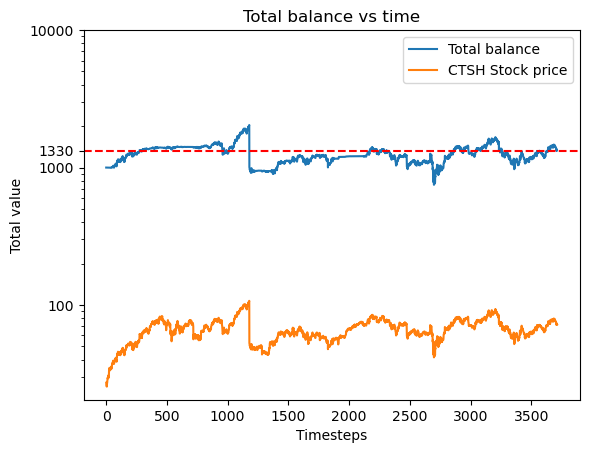

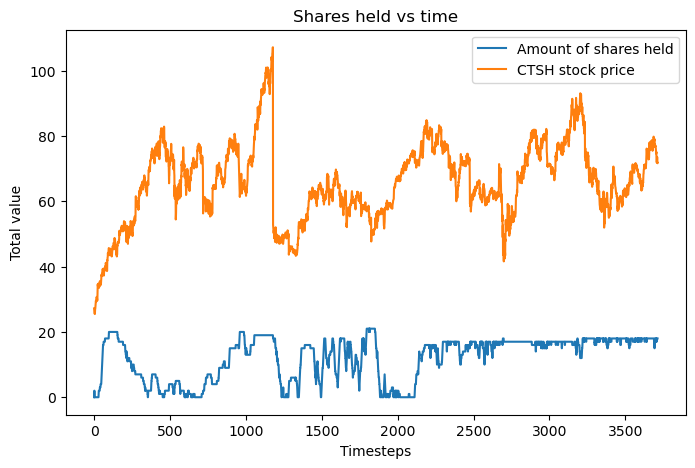

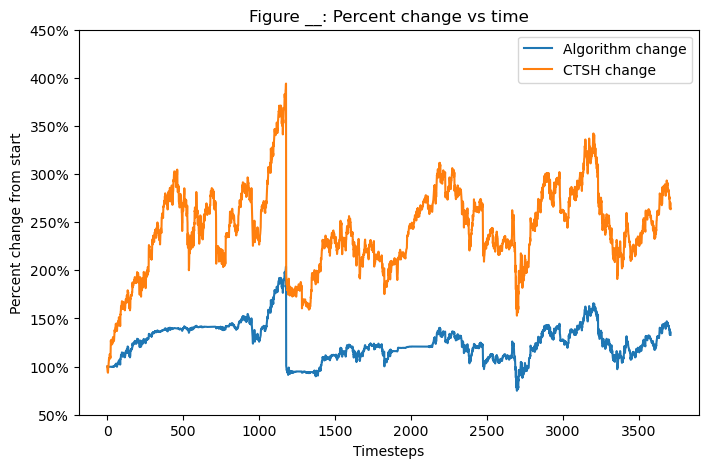

In [8]:
from matplotlib.ticker import ScalarFormatter

testing_data = pd.read_excel('Risk_Analysis_Data_Test.xlsx', sheet_name=None)

'''
Test stocks: 
- ORCL
- SONY
- SAP
- MU
- CTSH
- ANSS
- HPQ
- CSCO
'''
# Good stocks: ORCL, HPQ, CSCO
# Bad stocks: SONY, CTSH, MU


# Select stock here: 
test_stock_name = 'CTSH'


stock_data, stock_closing_prices = standardize_company_dataframe(testing_data[test_stock_name])

# Initialize chosen stock data and closing prices
test_stock_data = stock_data
test_closing_prices = stock_closing_prices


# Set epsilon to zero and get new parameters
test_params = Parameters(0.0)

# Initialize environment and DQN algorithm
env = Env(test_stock_data, test_closing_prices, 1000)
test_dqn = DQN(test_params.state_dim, test_params.action_dim, test_params)
test_dqn.load_weights()

can_buy = True
can_sell = False

test_balance = []

for episode in range(1):
    curr_reward = 0
    state = env.reset()
    curr_shares_held = []
    
    while True:
        with torch.no_grad():
            action = test_dqn.act(state, can_buy, can_sell)
            next_state, reward, done, can_buy, can_sell, next_stock = env.step(action, False)
        
        state = next_state
        curr_reward += reward
        curr_shares_held.append(env.shares)
        
        if done: break
            
        # Keep track of total balance 
        test_balance.append(env.get_total_balance())
        
        
print(f'Final reward: {curr_reward}')
print(f'Highest reward: {max(test_balance)}')

print(f'Stock initial value: {test_closing_prices[0]}')
print(f'Stock last value: {test_closing_prices[len(test_closing_prices) - 1]}')


# Plot stock price and algorithm total balance - log scaled
final_y = test_balance[-1]
plt.plot(test_balance, label="Total balance")
plt.plot(test_closing_prices, label=f"{test_stock_name} Stock price")
plt.title("Total balance vs time")
plt.xlabel("Timesteps")
plt.ylabel("Total value")
plt.yscale('log')
plt.axhline(y=final_y, color='r', linestyle='--')  # horizontal line at max_y
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.yticks(list(plt.yticks()[0])[2:len(list(plt.yticks()[0])) - 1] + [final_y])
plt.legend()
plt.show()


# Plot the shares held by the algorithm and stock price
plt.figure(figsize=(8, 5))
plt.plot(curr_shares_held, label="Amount of shares held")
plt.plot(test_closing_prices, label=f"{test_stock_name} stock price")
plt.title("Shares held vs time")
plt.xlabel("Timesteps")
plt.ylabel("Total value")
plt.legend()
plt.savefig(f'{test_stock_name}_shares_held.png')
plt.show()


# Plot the percent change of the algorithm's balance compared to the starting amount
# and plot the percent change of the stock

dqn_change = [bal / test_balance[0] for bal in test_balance]
stock_change = [price / test_closing_prices[0] for price in test_closing_prices]

plt.figure(figsize=(8, 5))
plt.plot(dqn_change, label="Algorithm change")
plt.plot(stock_change, label=f"{test_stock_name} change")
plt.title("Figure __: Percent change vs time")
plt.xlabel("Timesteps")
plt.ylabel("Percent change from start")
plt.yticks(plt.yticks()[0], [str(int(tick * 100)) + '%' for tick in plt.yticks()[0]])
plt.legend()
plt.savefig(f'{test_stock_name}_percent_change.png')
plt.show()
